In [1]:
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import bbknn
import random
import scipy.stats
import scipy.io
import sys
import scvelo as scv
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def combine_input_files_to_dataframe(file1_path, file2_path, file3_path, file4_path):
    # Read raw counts file to matrix.
    emtab7660_matrix = scipy.io.mmread(file1_path)

    # Read file with sample ids and store them in a list.
    columns_file = open(file2_path)
    sample_ids = columns_file.read().splitlines()

    # Read file with gene ensembl ids and store them in a list.
    rows_file = open(file3_path)
    gene_ensembl_ids = rows_file.read().splitlines()
    gene_ensembl_ids = [gene_ensembl_id.split("\t")[0] for gene_ensembl_id in gene_ensembl_ids]

    # Read  file with experimental design data.
    experimental_information_file = open(file4_path)
    # Get the sample characteristics stored for each sample in dataset and store them in a list. 
    # Example for sample characteristics : organism, strain, age, sampling site ...
    header = experimental_information_file.readline()
    list_sample_characteristics = [sample_characteristic for sample_characteristic in header.replace("\"","").replace("\n","").split("\t")]

    # For each sample characteristic store the values as a list in a dictionary.
    sample_characteristics_values_dict = {}
    experimental_information_tsv = pd.read_csv(file4_path, sep='\t')
    for sample_characteristic in list_sample_characteristics:
        sample_characteristics_values_dict[sample_characteristic] = experimental_information_tsv[sample_characteristic].tolist()


    matrix = emtab7660_matrix.todense()

    # Create a panda dataframe from counts matrix, sample_ids and gene_ensembl_ids.
    df = pd.DataFrame(matrix,index=gene_ensembl_ids, columns=sample_ids)
    result_df = sc.AnnData(df.transpose())

    # Add experimental design data to previously created dataframe.
    for sample_characteristic in list_sample_characteristics:
        result_df.obs[sample_characteristic] = sample_characteristics_values_dict[sample_characteristic]
 
    return result_df



# Raw counts file path.
raw_counts_file_path = '/Users/technodoc/Documents/STUDIUM/Bioinformatik/Bachelorarbeit/Datasets/E-MTAB-7660-quantification-raw-files/E-MTAB-7660.aggregated_filtered_counts.mtx'
# Sample ids file path.
sample_ids_file_path = '/Users/technodoc/Documents/STUDIUM/Bioinformatik/Bachelorarbeit/Datasets/E-MTAB-7660-quantification-raw-files/E-MTAB-7660.aggregated_filtered_counts.mtx_cols'
# Gene ensembl ids file path.
gene_ensembl_ids_file_path = '/Users/technodoc/Documents/STUDIUM/Bioinformatik/Bachelorarbeit/Datasets/E-MTAB-7660-quantification-raw-files/E-MTAB-7660.aggregated_filtered_counts.mtx_rows'
# Experimental information file path.
experimental_information_file_path = '/Users/technodoc/Documents/STUDIUM/Bioinformatik/Bachelorarbeit/Datasets/E-MTAB-7660-quantification-raw-files/ExpDesign-E-MTAB-7660.tsv'

# Combine input files to a dataframe.
adata_7660 = combine_input_files_to_dataframe(raw_counts_file_path, sample_ids_file_path, gene_ensembl_ids_file_path, experimental_information_file_path)

In [31]:
print(adata_7660.var_names)
print(adata_7660.n_obs)

Index(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000037',
       'ENSMUSG00000000049', 'ENSMUSG00000000056', 'ENSMUSG00000000058',
       'ENSMUSG00000000078', 'ENSMUSG00000000085', 'ENSMUSG00000000088',
       'ENSMUSG00000000120',
       ...
       'ENSMUSG00000118506', 'ENSMUSG00000118510', 'ENSMUSG00000118522',
       'ENSMUSG00000118537', 'ENSMUSG00000118552', 'ENSMUSG00000118555',
       'ENSMUSG00000118559', 'ENSMUSG00000118560', 'ENSMUSG00000118573',
       'ENSMUSG00000118626'],
      dtype='object', length=17590)
4266


In [3]:
# Print various information about sample characteristics.
print('All cells originate from organism part: ',str(set(adata_7660.obs['Sample Characteristic[organism part]'].values)).replace("{","").replace("}","").replace("'",""))
print('All cells are of type: ',str(set(adata_7660.obs['Sample Characteristic[cell type]'].values)).replace("{","").replace("}","").replace("'",""))
print('Cells were sampled from: ',str(set(adata_7660.obs['Sample Characteristic[sampling site]'].values)).replace("{","").replace("}","").replace("'",""))

All cells originate from organism part:  small intestine
All cells are of type:  intestinal epithelial cell
Cells were sampled from:  proximal small intestine


In [4]:
# Query mitochondrial_ensembl_gene_ids and store them in a list..
mitochondrial_ensembl_gene_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")
list_mitochondrial_ensembl_gene_ids = mitochondrial_ensembl_gene_ids['ensembl_gene_id'].values.tolist()

## Backup list in case server is down.
# list_mitochondrial_ensembl_gene_ids = ['ENSMUSG00000064336', 'ENSMUSG00000064337', 'ENSMUSG00000064338', 'ENSMUSG00000064339',
#'ENSMUSG00000064340', 'ENSMUSG00000064341', 'ENSMUSG00000064342', 'ENSMUSG00000064343', 'ENSMUSG00000064344',
#'ENSMUSG00000064345', 'ENSMUSG00000064346', 'ENSMUSG00000064347', 'ENSMUSG00000064348', 'ENSMUSG00000064349',
#'ENSMUSG00000064350', 'ENSMUSG00000064351', 'ENSMUSG00000064352', 'ENSMUSG00000064353', 'ENSMUSG00000064354',
#'ENSMUSG00000064355', 'ENSMUSG00000064356', 'ENSMUSG00000064357', 'ENSMUSG00000064358', 'ENSMUSG00000064359',
#'ENSMUSG00000064360', 'ENSMUSG00000064361', 'ENSMUSG00000065947', 'ENSMUSG00000064363', 'ENSMUSG00000064364',
#'ENSMUSG00000064365', 'ENSMUSG00000064366', 'ENSMUSG00000064367', 'ENSMUSG00000064368', 'ENSMUSG00000064369',
#'ENSMUSG00000064370', 'ENSMUSG00000064371', 'ENSMUSG00000064372']

# Print the mitochondrial ensembl gene ids present in our dataframe.
print([id for id in adata_7660.obs_names if id in list_mitochondrial_ensembl_gene_ids])

# ['ENSMUSG00000064341', 'ENSMUSG00000064345', 'ENSMUSG00000064351', 'ENSMUSG00000064354', 'ENSMUSG00000064356',
#'ENSMUSG00000064357', 'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000064363', 'ENSMUSG00000064367', 
#'ENSMUSG00000064368', 'ENSMUSG00000064370', 'ENSMUSG00000065947']

[]


In [5]:
# For each ensembl_gene_ids store true if they are mitochondrial.
adata_7660.var['mitochondrial'] = adata_7660.var_names.isin(list_mitochondrial_ensembl_gene_ids)
# Calculate quality metrics.
sc.pp.calculate_qc_metrics(adata_7660, qc_vars=["mitochondrial"], percent_top=None, log1p=False, inplace=True)

... storing 'Sample Characteristic[organism]' as categorical
... storing 'Sample Characteristic Ontology Term[organism]' as categorical
... storing 'Sample Characteristic[strain]' as categorical
... storing 'Sample Characteristic[age]' as categorical
... storing 'Sample Characteristic[developmental stage]' as categorical
... storing 'Sample Characteristic Ontology Term[developmental stage]' as categorical
... storing 'Sample Characteristic[sex]' as categorical
... storing 'Sample Characteristic Ontology Term[sex]' as categorical
... storing 'Sample Characteristic[individual]' as categorical
... storing 'Sample Characteristic[genotype]' as categorical
... storing 'Sample Characteristic[organism part]' as categorical
... storing 'Sample Characteristic Ontology Term[organism part]' as categorical
... storing 'Sample Characteristic[sampling site]' as categorical
... storing 'Sample Characteristic Ontology Term[sampling site]' as categorical
... storing 'Sample Characteristic[cell type]' as

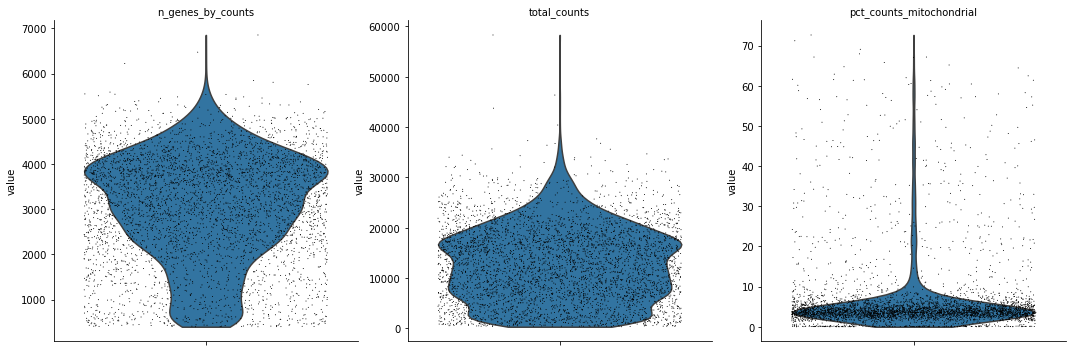

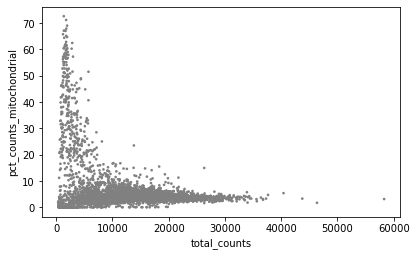

In [6]:
# Generate quality control information plot.
sc.pl.violin(adata_7660, ['n_genes_by_counts', 'total_counts', 'pct_counts_mitochondrial'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_7660, x='total_counts', y='pct_counts_mitochondrial')

In [7]:

def filter_samples(data,pct_counts_mitochondrial_threshold,n_genes_by_counts_threshold,total_counts_threshold ):
    """ Filters samples using desired threshold values for quality control metrics. """
    
    data = data[data.obs.pct_counts_mitochondrial <= pct_counts_mitochondrial_threshold] 

    data = data[data.obs.n_genes_by_counts <= n_genes_by_counts_threshold] 

    data = data[data.obs.total_counts <= total_counts_threshold] 
    
    return data

# Filter samples using threshold values for quality control metrics.
adata_7660 = filter_samples(adata_7660, 10, 4_000, 20_000)

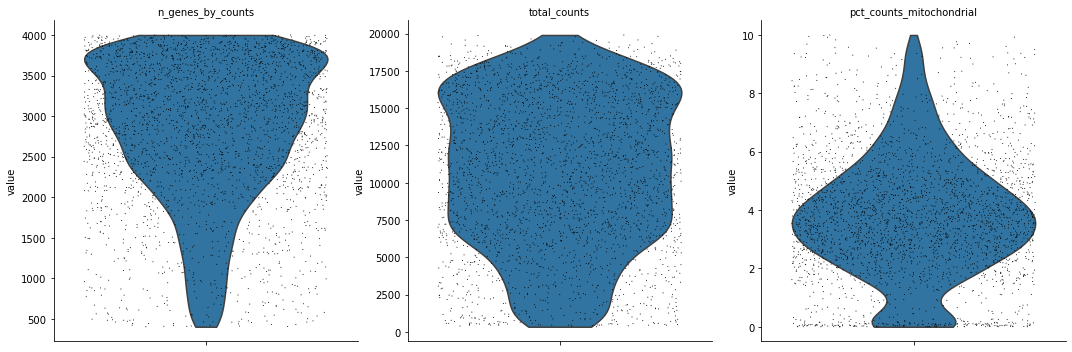

In [8]:
# Generate violin plot for quality control information.
sc.pl.violin(adata_7660, ['n_genes_by_counts', 'total_counts', 'pct_counts_mitochondrial'],
             jitter=0.4, multi_panel=True)

In [9]:
# Save raw counts values in layer "counts" before applying normalisation methods on these values.
adata_7660.layers["counts"] = adata_7660.X.copy()
############ Make a copy
copy = adata_7660.copy()

Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

In [10]:
sc.pp.normalize_total(adata_7660, target_sum=1e4)

Logarithmize the data matrix.

In [11]:
sc.pp.log1p(adata_7660, base=2) 

Identify highly-variable genes.

In [12]:
sc.pp.highly_variable_genes(
    adata_7660,
    n_top_genes=2000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)

Plot highly-variable genes.

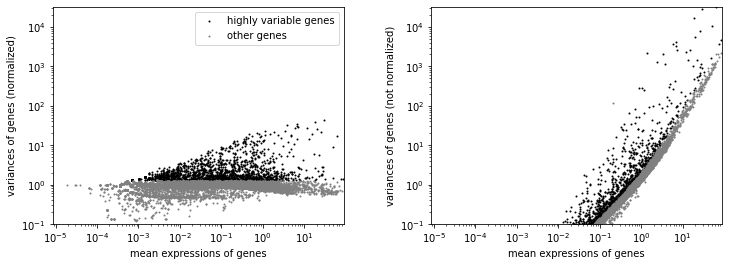

In [13]:
sc.pl.highly_variable_genes(adata_7660, log=True)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [14]:
adata_7660.raw = adata_7660 

Filter the genes.

In [15]:
adata_7660 = adata_7660[:, adata_7660.var.highly_variable].copy()

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed  using simple linear regression.

In [16]:
sc.pp.regress_out(adata_7660, ['total_counts', 'pct_counts_mitochondrial'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [17]:
sc.pp.scale(adata_7660, max_value=10)

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

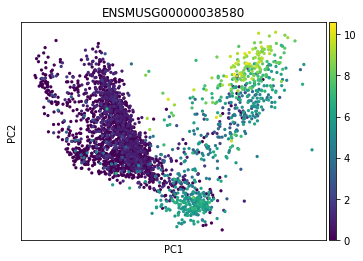

In [18]:
sc.tl.pca(adata_7660)
sc.pl.pca(adata_7660, color='ENSMUSG00000038580')

Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells in louvain or tSNE.

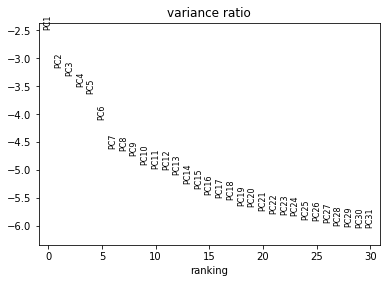

In [19]:
sc.pl.pca_variance_ratio(adata_7660, log=True)

Compute the neighborhood graph of cells using the PCA representation of the data matrix. 

In [20]:
sc.pp.neighbors(adata_7660, n_pcs= 10, n_neighbors = 20) 

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
hormone_id_dict = {'SCT':'ENSMUSG00000038580',
                  'GIP':'ENSMUSG00000014351',
                  'CCK':'ENSMUSG00000032532',
                  'NTS':'ENSMUSG00000019890',
                  'PYY':'ENSMUSG00000017311',
                  'TAC1':'ENSMUSG00000061762'
                 }

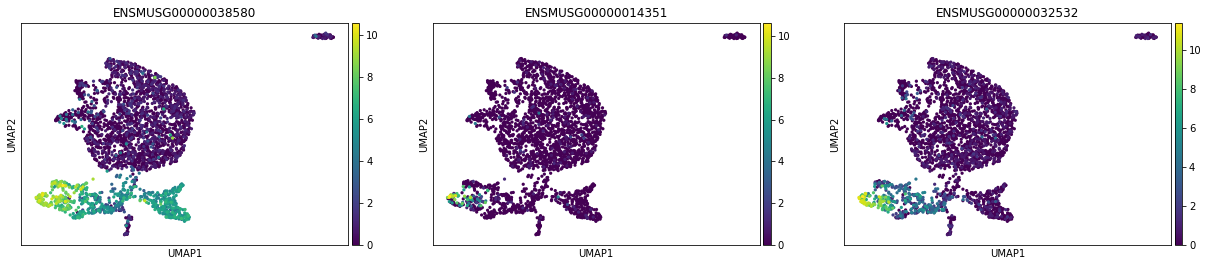

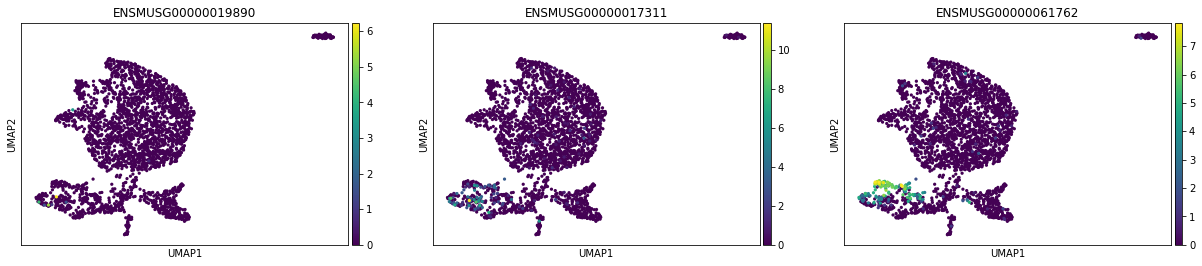

In [22]:
sc.tl.umap(adata_7660)
sc.pl.umap(adata_7660, color=['ENSMUSG00000038580','ENSMUSG00000014351','ENSMUSG00000032532'],use_raw=True, ncols = 3, hspace = 0.8)
sc.pl.umap(adata_7660, color=['ENSMUSG00000019890','ENSMUSG00000017311','ENSMUSG00000061762'],use_raw=True, ncols = 3, hspace = 0.8)

print(adata_7660['SAMEA5374488-AAACCTGAGAGGTAGA','ENSMUSG00000038580'].X.item())

Hormone     Mean expression             Std                    Min                 Max         

SCT       -1.1534923254631066e-09   0.9998252176950961         -1.4225596189498901       3.1571474075317383 
GIP       -0.00044724953698016486   0.9952001953167325         -0.4617098867893219              10.0        
CCK       -4.880715419376534e-10   0.9998252207181278          -0.948284924030304       5.830849647521973  
NTS       -0.021311015414550334   0.45013307597514735        -0.13764292001724243             10.0        
PYY       -0.005446309031239237   0.9291450242610871         -0.43655282258987427             10.0        
TAC1      8.871378533331217e-10   0.9998252227014485          -0.605800211429596       7.638801097869873  


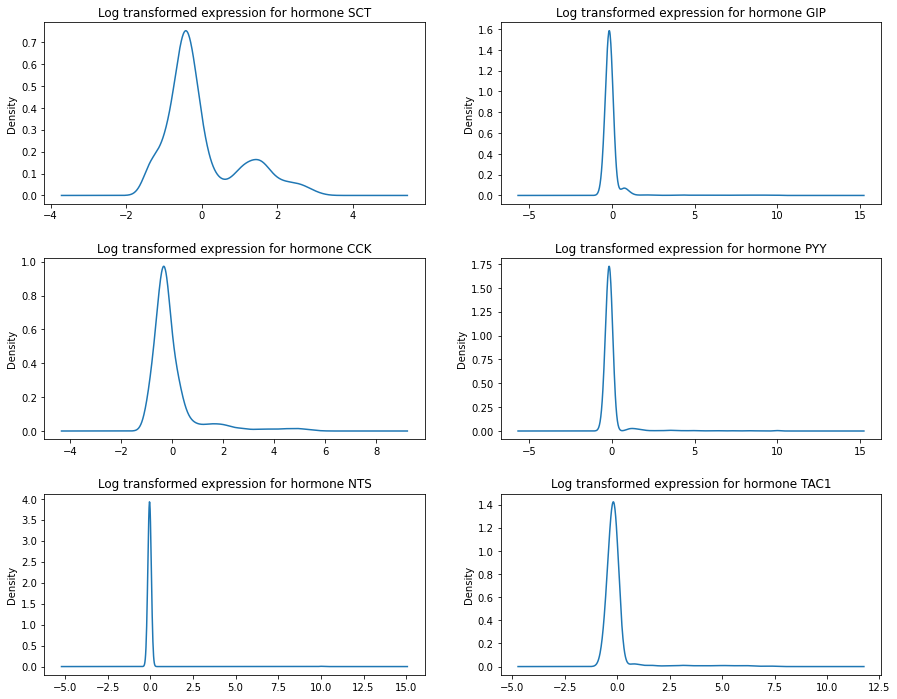

In [23]:
def get_hormone_expression_dict(hormone_id_dict):
    """
    Input: A dictionary with hormone gene id as key, and its ensembl id as value.
    Output: A dictionary with hormone gene id as key and a list of expression values of all samples for that hormone as value.
    """
    # TODO: Dataframe should be gives as a function parameter.

    hormone_expression_values = {}
    for hormone in hormone_id_dict.keys():
        s2 = adata_7660[:,adata_7660.var_names.str.fullmatch(hormone_id_dict[hormone])]
        str_list = str((s2.X).tolist()).replace('[[','A').replace(']]','B').replace(']','').replace('[','').replace('A','').replace('B','').split(',')
        float_list =  [float(i.strip()) for i in str_list]
        hormone_expression_values[hormone] = float_list
    
    return hormone_expression_values
        
        
def extract_expression_info(hormone_id_dictionary):
    """
    Input:  - A dictionary with hormone gene id as key, and its ensembl id as value.
    Output: - Prints mean, std, min and max hormonal expression for each hormone in dictionary.
            - Generates density plots of hormonal expression for each hormone in dictionary.
    """
    
    # Get dictionary with hormone gene id as key and a list of expression values of all samples for that hormone as value.
    hormone_expression_values = get_hormone_expression_dict(hormone_id_dictionary)
    
    # Store mean, std, min and max values for each hormone.
    mean_expression_by_hormone = {}
    std_expression_by_hormone = {} 
    max_expression_for_hormone = {}
    min_expression_for_hormone = {}
    
    
    a = 'Hormone'
    b = 'Mean expression'
    c = "Std "
    d = "Min"
    e = "Max"
    
    print(f"{a : <10}{b: ^20}{c: ^25}{d: ^20}{e: ^20}\n")
    
    # Generate plots
    fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2,figsize=(15,12),gridspec_kw={'hspace':0.3})
    
    # TODO: generate axis hormone map using hormone_id_dictionary
    axis_hormone_map = {'SCT': ax1,'GIP': ax2,'CCK': ax3,'PYY': ax4, 'NTS': ax5, 'TAC1': ax6}
         
    for hor, values in hormone_expression_values.items():
        
        
        hormone_max = np.amax(values)
        hormone_min = np.amin(values)
        expression_mean_by_hormone = np.mean(values)
        expression_std_by_hormone = np.std(values)
        
        max_expression_for_hormone[hor] = hormone_max
        min_expression_for_hormone[hor] = hormone_min
        
        mean_expression_by_hormone[hor] = expression_mean_by_hormone
        std_expression_by_hormone[hor] = expression_std_by_hormone

        
        print(f"{hor : <10}{expression_mean_by_hormone : ^20}{expression_std_by_hormone : ^25}{hormone_min : ^30}{hormone_max : ^20}")
    

        values = pd.Series(values)
        ax=axis_hormone_map[hor]
        values.plot.kde(ax=ax)
        ax.set_title("Log transformed expression for hormone " + hor)

        
# Print hormonal expression information for samples in dataset.        
extract_expression_info(hormone_id_dict)

# Get dictionary with hormone gene id as key and a list of expression values of all samples for that hormone as value.
hor_expr_dict = get_hormone_expression_dict(hormone_id_dict)

In [24]:
def select_top_candidates(df,ids_dict):
    """
    Input: - Dataframe from which candidates are to be choosen.
           - A dictionary with hormone gene id as key, and its ensembl id as value.
           - List with threshold values for mean hormonal expression.
    Output: - The input dataframe information is extended and returned.
              (For each sample and each hormone we store True if the expression value
              is greater than the threshold expression value of that hormone.)
    """
    
    # TODO: Input threshold values as list. List is funtion parameter.
    mean_cut_off_values_dict = {
              'SCT': 2.1,
              'GIP': 1.5,
              'CCK': 1.5,
              'NTS': 2,
              'PYY': 1.7,
              'TAC1': 2.3
    }
    
    df = df.copy()

    
    # Create new observations for cells
    # Set boolean to False(cell is not a candidate with high hormone expression)
    for gene_id in ids_dict.keys():
        df.obs[gene_id] = df.obs_names.str.startswith("-+*/sdasd") 
    
    # Check that all boolean were set corretly.
    for gene_id in ids_dict.keys():
        print(gene_id + ' candidate boolean values were all set to',str(all(set(df.obs[gene_id].values)))+ ".")
    
    # Set for each cell
    for i in range(len(df.obs_names)):
        # For each hormone
        for gene_id, ensembl_id in ids_dict.items():
            # Possible candidates that have mean above mean threshold value. 
            if df[df.obs_names[i],ensembl_id].X >= mean_cut_off_values_dict[gene_id] :
                df[df.obs_names[i],ensembl_id].obs[gene_id][0] = True
                #print(gene_id,df.obs_names[i],df[df.obs_names[i],ensembl_id].X.item(), mean_cut_off_values_dict[gene_id],df[df.obs_names[i],ensembl_id].obs[gene_id][0])
    
    print("\nThe candidate boolean values for SCT, GIP, CCK, NTS, PYY, TAC1 were updated.")
    return df

   
adata_7660 = select_top_candidates(adata_7660, hormone_id_dict)

SCT candidate boolean values were all set to False.
GIP candidate boolean values were all set to False.
CCK candidate boolean values were all set to False.
NTS candidate boolean values were all set to False.
PYY candidate boolean values were all set to False.
TAC1 candidate boolean values were all set to False.

The candidate boolean values for SCT, GIP, CCK, NTS, PYY, TAC1 were updated.


In [25]:
def get_all_candidates(adata_7660):
    """
    Input:  - Dataframe from which candidates are to be choosen.
    Output: - List of unique sample ids that have a significant expression of at least one hormone.
            - Prints mean, std, min and max hormonal expression for each hormone in dictionary.
    """
    
    # TODO: Hormone id dict as function parameter.
    
    a = 'Hormone'
    b = '#Samples'
    c = "Min mean"
    d = "Mean of means"
    e = "Max mean"
    
    list_of_all_candidates = []
    print(f"{a : <10}{b: ^20}{c: ^20}{d: ^20}{e: ^20}\n")
    for gene_id in hormone_id_dict.keys():
        view = adata_7660.copy()
        view = view[:,view.var_names.str.fullmatch(hormone_id_dict[gene_id])]
        view = view[view.obs[gene_id].isin([True])]
        list_of_all_candidates.extend(view.obs_names.values.tolist())
        #print(gene_id, view.n_obs, np.amin(view.X), np.mean(view.X))
        print(f"{gene_id : <10}{view.n_obs : ^20}{np.amin(view.X) : ^20}{np.mean(view.X) : ^20}{np.amax(view.X) : ^20}")
    print("\n", "#total samples:   ",len(list_of_all_candidates))
    print("\n", "#total unique samples: ",len(set(list_of_all_candidates)))
    return list_of_all_candidates



candidates_list = get_all_candidates(adata_7660)  

Hormone         #Samples            Min mean         Mean of means          Max mean      

SCT               138           2.10211443901062    2.52396297454834   3.1571474075317383 
GIP                67          1.543344259262085   5.706551551818848          10.0        
CCK               174          1.8080308437347412  3.2986414432525635  5.830849647521973  
NTS                8           3.5788230895996094  8.128655433654785          10.0        
PYY                76          1.7030757665634155  4.824100017547607          10.0        
TAC1              106          2.3365728855133057  4.703727722167969   7.638801097869873  

 #total samples:    569

 #total unique samples:  294


In [26]:
def color_negative_red(val):
    """
    Input: Single dataframe value.
    Output: Green if value == True. Red if value == False.
    """
    
    color = 'red' if val == False else 'green'
    return 'color: %s' % color
    
def create_table(df, list_obs):
    """
    Input:  - Dataframe with values.
            - List of unique sample ids that have a significant expression of at least one hormone. 
    Output: - Dataframe with sample ids as rows, hormones as columns.
              For each sample and each hormone True is stored if the expression value
              is greater than the threshold expression value of that hormone.
    """
    
    df = df[df.obs_names.isin(list_obs)]
    rows_df = df.obs_names.values
    dict_of_columns_df = {}
    for gene_id in hormone_id_dict.keys():
        dict_of_columns_df[gene_id]=  df.obs[gene_id].values

    new_df = pd.DataFrame(dict_of_columns_df,index=rows_df)
    return new_df

# Generate new table for hromonal expression of each sample.
new_df = create_table(adata_7660, candidates_list)
# Apply color map to dataframe values.
new_df.style.applymap(color_negative_red)

,SCT,GIP,CCK,NTS,PYY,TAC1
SAMEA5374488-AAAGATGAGTTTAGGA,False,False,True,False,False,False
SAMEA5374488-AACACGTAGAATGTGT,False,False,False,False,False,True
SAMEA5374488-AACACGTCACAGCGTC,False,False,True,False,False,False
SAMEA5374488-AACGTTGGTTGATTCG,False,False,True,False,False,False
SAMEA5374488-AACTCAGGTTTGGGCC,True,False,False,False,False,True
SAMEA5374488-AACTCCCGTCCTGCTT,False,False,False,False,False,True
SAMEA5374488-AACTGGTAGCACCGTC,True,False,False,False,False,False
SAMEA5374488-AACTTTCCAGCTCGAC,True,False,True,False,False,False
SAMEA5374488-AACTTTCTCCCATTTA,True,False,True,False,False,False
SAMEA5374488-AAGCAGTGGTATCAAC,False,True,False,False,False,False


Summary 

1 hormone expressed: 126
2 hormones expressed: 82
3 hormones expressed: 68
4 hormones expressed: 15
5 hormones expressed: 3



1 hormone expressed 

CCK hormones expressed: 53
TAC1 hormones expressed: 24
PYY hormones expressed: 23
GIP hormones expressed: 15
SCT hormones expressed: 9
NTS hormones expressed: 2



2 hormones expressed 

SCT,TAC1 hormones expressed: 24
SCT,CCK hormones expressed: 21
CCK,PYY hormones expressed: 11
CCK,TAC1 hormones expressed: 9
PYY,TAC1 hormones expressed: 6
SCT,GIP hormones expressed: 4
GIP,CCK hormones expressed: 3
SCT,PYY hormones expressed: 3
GIP,TAC1 hormones expressed: 1



3 hormones expressed 

SCT,GIP,CCK hormones expressed: 19
SCT,CCK,TAC1 hormones expressed: 16
SCT,CCK,PYY hormones expressed: 13
GIP,CCK,TAC1 hormones expressed: 4
SCT,PYY,TAC1 hormones expressed: 4
SCT,CCK,NTS hormones expressed: 3
SCT,GIP,TAC1 hormones expressed: 3
CCK,PYY,TAC1 hormones expressed: 3
GIP,CCK,PYY hormones expressed: 2
SCT,GIP,PYY hormones expressed: 1





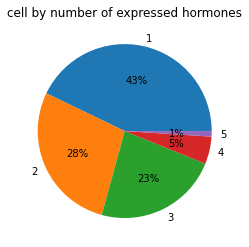

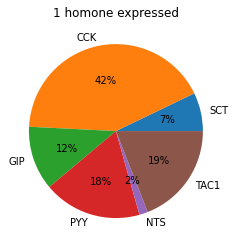

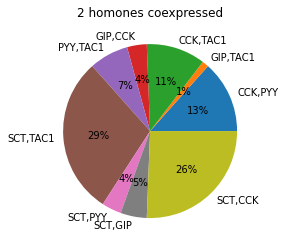

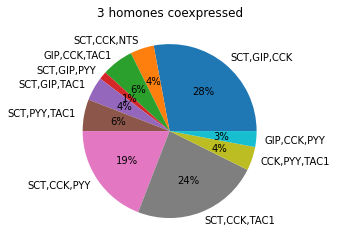

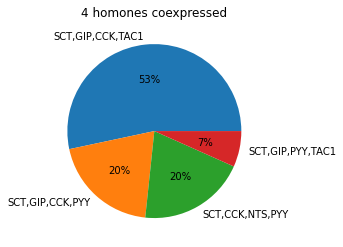

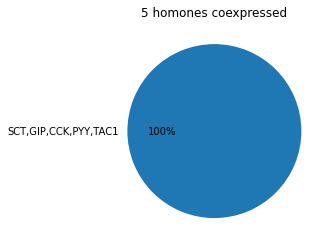

In [27]:
def plot_pie_chart(annotat_count, title):
    labels = []
    sizes = []
    
    print("Summary \n")
    for label, size in annotat_count.items():
        labels.append(label)
        sizes.append(size)
        if label == 1:
            print(str(label) + " hormone expressed: " +str(size))
        else:
            print(str(label) + " hormones expressed: " +str(size))
    print("\n")
    
    
    colours = {}
    i = 0
    for label in annotat_count.keys():
        col_code = 'C'+ str(i)
        colours[label] = col_code
        i = i + 1
    
    fig, ax = plt.subplots(1, 1)
    ax.pie(sizes,
          labels=labels,
          colors=[colours[key] for key in labels],autopct='%1.0f%%')
    ax.set_title(title)

def plot_pie_chart2(list_dictionary, title, number_coexpressed):
    labels = []
    sizes = []
    dict_comb_value = {}
    
    
    if number_coexpressed == 1:
        print("\n" + str(number_coexpressed) + " hormone expressed \n")
    else:
        print("\n" + str(number_coexpressed) + " hormones expressed \n")
        
    for dictionary in list_dictionary:
        label = list(dictionary.keys())[0]
        size = list(dictionary.values())[0]
        labels.append(label)
        sizes.append(size)
        dict_comb_value[label] = size
       #print(str(label) + " hormones expressed: " +str(size))
    
    sorted_dict_comb_value = dict(sorted(dict_comb_value.items(), key=lambda item: item[1], reverse=True))
    for hormone_coexpr, number_cells in sorted_dict_comb_value.items():
           print(str(hormone_coexpr) + " hormones expressed: " +str(number_cells))
             
    print("\n")

    colours = {}
    i = 0
    for dictionary in list_dictionary:
        col_code = 'C'+ str(i)
        colours[list(dictionary.keys())[0]] = col_code
        i = i + 1
    
    fig, ax = plt.subplots(1, 1)
    ax.pie(sizes,
          labels=labels,
          colors=[colours[key] for key in labels],autopct='%1.0f%%')
    ax.set_title(title)
    
    
def generate_plot_data(data):
    dict_total_coexpressed_counts = {1:0,2:0,3:0,4:0,5:0}
    dict_total_coexpressed_strings = {1:[],2:[],3:[],4:[],5:[]}
    dict_grouped_coexpressed_strings = {1:[],2:[],3:[],4:[],5:[]}

    list_of_rows = []
    cell_ids = data.index
    for cell_id in data.index:
        row = data.loc[cell_id]
        list_of_rows.append(row.tolist())

    
    unique_data = [list(x) for x in set(tuple(x) for x in list_of_rows)]
    #print(unique_data)
    #print(len(unique_data))
    list_hormones = data.columns.tolist()

    dict_index_hormone = {}
    for idx, hormone in enumerate(list_hormones):
        dict_index_hormone[idx] = hormone
     
    #print(dict_index_hormone)
        
    dict_possible_combinations_string_count = {}
    dict_possible_combinations_string_list = {}
    for unique_data in unique_data:
        combination_name = ''
        for idx, value in enumerate(unique_data):
            if value == True:
                combination_name += dict_index_hormone[idx] + ','
        combination_name = combination_name.rstrip(',')
        dict_possible_combinations_string_count[combination_name] = 0
        dict_possible_combinations_string_list[combination_name] = unique_data
    
    #print(dict_possible_combinations_string_count)
    #print(dict_possible_combinations_string_list)
    #print(len(dict_possible_combinations))
    
    for possible_combination in dict_possible_combinations_string_count.keys():
        number_hormones_expressed = possible_combination.count(',') + 1
        dict_total_coexpressed_strings[number_hormones_expressed].append(possible_combination)
    
    #print(dict_total_coexpressed_strings)
    
    for cell_id in cell_ids:
        row = data.loc[cell_id].tolist()
        for key, value in dict_possible_combinations_string_list.items():
            if value == row:
                dict_possible_combinations_string_count[key] += 1
        
    #print(dict_possible_combinations_string_count)
    
    for key, list_of_lists in dict_total_coexpressed_strings.items():
        for element in list_of_lists:
            dict_grouped_coexpressed_strings[key].append({element:dict_possible_combinations_string_count[element]})
            
    for key, list_dicts in dict_grouped_coexpressed_strings.items():
        for dictionary in list_dicts:
            dict_total_coexpressed_counts[key] += list(dictionary.values())[0]
            
    return (dict_total_coexpressed_counts,dict_grouped_coexpressed_strings)    
    
     
result = generate_plot_data(new_df) 
different_number_expressions_dict = result[0]
grouped_number_expressions_dict = result[1]
plot_pie_chart(different_number_expressions_dict, 'cell by number of expressed hormones')

for i in  range(1,6):
    if i == 1:
        plot_pie_chart2(grouped_number_expressions_dict[i], str(i) + ' homone expressed', i)
    else:
        plot_pie_chart2(grouped_number_expressions_dict[i], str(i) + ' homones coexpressed' , i)
